In [2]:
import sys
sys.path.append('../')

In [14]:
## LARYNGEAL TISSUE DATASET
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras import backend as K
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from importlib import reload
import libs.analysis as analysis
import libs.importing as importing
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

In [15]:
import numpy as np
import pandas as pd
import os

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [18]:


# load the data
src_dir = '../data/d59fe403'

images_dir = os.path.join(src_dir, 'patches')
train_df = pd.read_csv( os.path.join(src_dir, 'train2.csv') )
test_df = pd.read_csv( os.path.join(src_dir, 'test2.csv') )
val_df = pd.read_csv( os.path.join(src_dir, 'val2.csv') )

train_importer = importing.PatchDataReader(images_dir, train_df)
x_train, y_train = train_importer.read_data()

test_importer = importing.PatchDataReader(images_dir, test_df)
x_test, y_test = test_importer.read_data()

val_importer = importing.PatchDataReader(images_dir, val_df)
x_val, y_val = val_importer.read_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)


(11760, 64, 64, 3)
(11760,)
(2352, 64, 64, 3)
(2352,)
(1568, 64, 64, 3)
(1568,)


In [19]:
# Parameters
batch_size = 32
epochs = 10
num_classes = 3

patch_size = 64

img_rows, img_cols = (patch_size, patch_size)

# Model Destination
model_dest_file = '01_clean_model.h5'

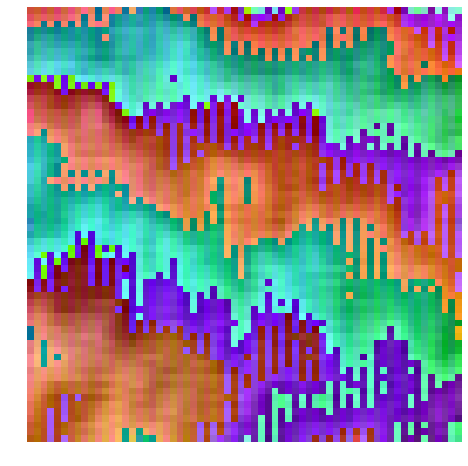

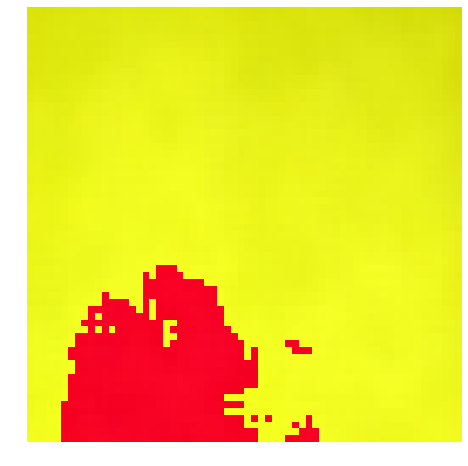

In [20]:
## DATA NORMALIZATION
import libs.normalization as norm
import libs.render as render

# calculate the mean for the training data: this becomes part of our model
train_mean, train_std = norm.dataset_mean_and_std(x_train)

# Let's see what the mean image and std look like
render.plot_image(train_mean)
render.plot_image(train_mean / train_std)

# normalize the train, test, and validation data
x_train -= train_mean
x_train /= train_std

x_test -= train_mean
x_test /= train_std

x_val -= train_mean
x_val /= train_std



In [21]:
import keras
# Label Normalization : We will merge dysplasia and carcinomas
num_classes = 3

# Merge dysplasias <=> carcinomas
y_train[y_train == 3] = 2
y_test[y_test == 3] = 2
y_val[y_val == 3] = 2


y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_test_oh = keras.utils.to_categorical(y_test, num_classes)
y_val_oh = keras.utils.to_categorical(y_val, num_classes)

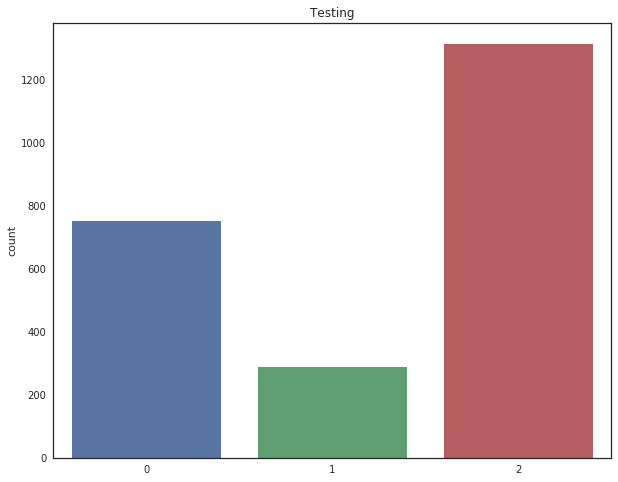

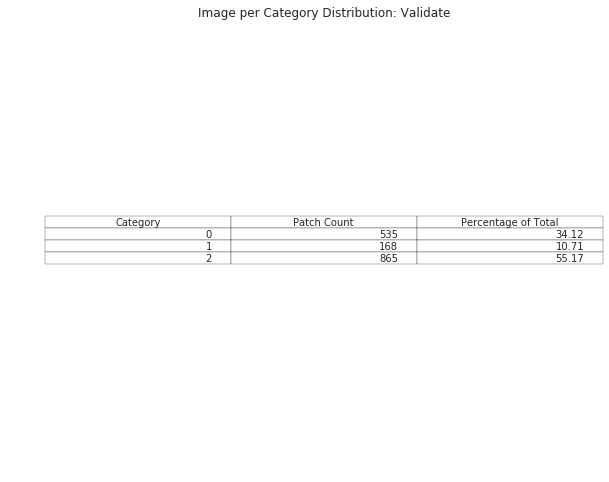

In [22]:
## Viewing Distribution
reload(render)

plt.title('Training')
sns.countplot(y_train)
plt.show()
plt.title('Testing')
sns.countplot(y_test)
plt.show()
plt.title('Validation')
sns.countplot(y_val)
plt.show()

render.plot_patches_per_category_distribution(y_train, 'Train', num_classes=3)
render.plot_patches_per_category_distribution(y_test, 'Test', num_classes=3)
render.plot_patches_per_category_distribution(y_val, 'Validate', num_classes=3)

In [ ]:
# if we're loading a model load it!
model = load_model(model_dest_file)

In [55]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', input_shape = (64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 48, kernel_size = (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same'))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

In [56]:
# Define the optimizer
learning_rate = 0.1e-3
decay = 1e-6

optimizer = RMSprop(lr=learning_rate, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [57]:
batch_size = 64

# increase the epochs to tune up the accuracy of the model
epochs = 15

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=15,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15,                     # Randomly zoom image 
        width_shift_range=0.15,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                   # randomly flip images


#datagen.fit(x_train)


# Fit i.e. train the model
history = model.fit(x_train, y_train_oh, batch_size=batch_size, epochs=epochs,
                      verbose=1, validation_data=(x_test, y_test_oh), callbacks=[learning_rate_reduction])

#history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size),
#                              epochs = epochs, validation_data = (x_test,y_test_oh),
#                              workers = 8,
#                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
#                              , callbacks=[learning_rate_reduction])

Train on 11760 samples, validate on 2352 samples
Epoch 1/15
11760/11760 [==============================] - 12s 1ms/step - loss: 0.8396 - acc: 0.6554 - val_loss: 0.8319 - val_acc: 0.6726
Epoch 2/15
11760/11760 [==============================] - 11s 937us/step - loss: 0.7771 - acc: 0.6781 - val_loss: 0.8200 - val_acc: 0.6743
Epoch 3/15
11760/11760 [==============================] - 11s 937us/step - loss: 0.7589 - acc: 0.6849 - val_loss: 0.7452 - val_acc: 0.6866
Epoch 4/15
11760/11760 [==============================] - 11s 937us/step - loss: 0.7325 - acc: 0.6887 - val_loss: 0.7579 - val_acc: 0.6828
Epoch 5/15
11760/11760 [==============================] - 11s 936us/step - loss: 0.7150 - acc: 0.6896 - val_loss: 0.7422 - val_acc: 0.6879
Epoch 6/15
11760/11760 [==============================] - 11s 938us/step - loss: 0.6995 - acc: 0.6951 - val_loss: 0.7113 - val_acc: 0.6918
Epoch 7/15
11760/11760 [==============================] - 11s 934us/step - loss: 0.6864 - acc: 0.6933 - val_loss: 0.706

In [ ]:
# Save the model data
model_dest_file = '01_clean_model_v2.h5'
model.save(model_dest_file)

In [ ]:
# Now Let's evaluate the model
score = model.evaluate(x_test, y_test_oh, verbose=1)

In [51]:
# View the Final Loss and Accuracy scores across all epochs
analysis.print_loss_and_accuracy_from_score(score)

Test loss: 0.6971983696733203
Test accuracy: 0.7083333333333334


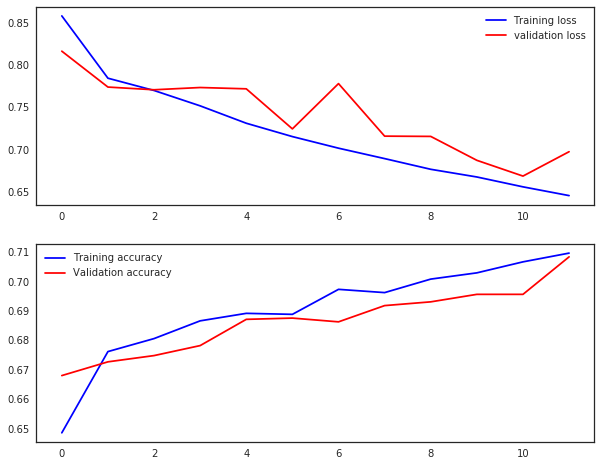

In [52]:
# View the Loss and Accuracy curves across the epochs
analysis.plot_loss_and_accuracy_curves(history, save=True)

In [53]:
reload(analysis)
y_pred = model.predict(x_test)
analysis.plot_confusion_matrix(y_test_oh, y_pred, classes=range(3), save=False)

In [54]:
reload(analysis)
scores = analysis.get_scores_oh(y_test_oh, y_pred)
analysis.print_scores(scores)

Precision (specificity): 63.864%
Recall (sensitivity): 62.251%
Accuracy: 70.833%
F1: 62.851%
